In [1]:
import pandas as pd
import numpy as np
import warnings
import ast
import datetime
warnings.filterwarnings('ignore')


Cargamos las bases necesarias para el requerimiento

In [2]:
movies = pd.read_csv('movies_dataset.csv')
credits = pd.read_csv('credits.csv')

Los valores nulos de los campos revenue, budget se rellenan con el número 0.



In [3]:
movies['revenue'].fillna(0, inplace=True)
movies['budget'].fillna(0, inplace=True)

Se eliminan los duplicados de ambas bases de datos y se cambia el tipo de dato de la columna id de ambas bases y el tipo de dato Budget de la base movies. Se eliminan valores errados de movies. 

In [4]:
credits.drop_duplicates(['id'], inplace = True)
credits['id'] = credits['id'].astype(int, copy=True, errors='raise')
movies.drop_duplicates(['id'], inplace = True)
movies.drop(movies[(movies['id'] == '1997-08-20') | (movies['id'] == '2014-01-01') | (movies['id'] == '2012-09-29')].index, inplace = True)
movies['id'] = movies['id'].astype(int, copy=True, errors='raise')
movies['budget'] = movies['budget'].astype(float, copy=True, errors='raise')


Se unen las bases a través del id de la película y se eliminan las columnas innecesarias para el análisis

In [5]:
movies = movies.merge(credits, on = 'id')
movies.drop(columns = ['homepage','tagline','video','imdb_id','adult','original_title','poster_path','homepage'], inplace =  True)

Ahora desanidamos las columnas crew y cast de la nueva base de datos

In [6]:
def convert(object): # función para desanidar genero y obtener una lista con los generos así como 
    list = []        # Spoken_languaje
    for i in ast.literal_eval(object):
        list.append(i['name'])
    
    return list

In [7]:
def convert_cast(object): #función para desaninar los 5 primeros actores pricipales de las peliculas
    list = []
    counter = 0
    for i in ast.literal_eval(object):
        if counter != 5:
            list.append(i['name'])
            counter += 1
        else:
            break
    
    return list

In [8]:
def convert_direct(object): #Función para desanidar los directores de cada una de las películas
    list = []
    for i in ast.literal_eval(object):
        if i['job'] == 'Director':
            list.append(i['name'])
            break
    
    return list

s las funciones creadas para desanidar y crear las listas correspondientes

In [9]:
movies['genres'] = movies['genres'].apply(convert)
movies['cast'] = movies['cast'].apply(convert_cast)
movies['crew'] = movies['crew'].apply(convert_direct)
movies.rename(columns={'crew':'Director'}, inplace = True)

Por último unimos los strig que tienen una separación o espacio entre palabras para mejorar la busqueda en las funciones 4 y 5 (Ejemplo: Tom Hanks - TomHanks)

In [10]:
movies ['genres'] = movies['genres'].apply(lambda x:[i.replace(' ','') for i in x])
movies['cast'] = movies['cast'].apply(lambda x:[i.replace(' ','') for i in x])
movies['Director'] = movies['Director'].apply(lambda x:[i.replace(' ','') for i in x])

Las fechas, se cambian al formato datetime AAAA-mm-dd, además se crear la columna release_year donde extraerán el año de la fecha de estreno. Y además se eliminan los valores nulos del campo release_date.



In [11]:
# Se crea la función de transformacion de strin a Datetime
def str_to_date(time):
    if len(time) < 10:
        return None
    else:
        return datetime.datetime.strptime(time,'%Y-%m-%d')

In [12]:
movies = movies.dropna(subset=['release_date'])
movies['release_date'] = movies['release_date'].apply(str_to_date)
movies['release_year'] = movies['release_date'].dt.year

Se crea la columna con el retorno de inversión, llamada return con los campos revenue y budget, dividiendo estas dos últimas revenue / budget, cuando no hay datos disponibles para calcularlo, se retorna cero tomar el valor 0.

In [13]:
movies['return'] = round(movies['revenue'] / movies['budget'], 6) #división
movies['return'] = movies['return'].fillna(0) #retornar cero en los nulos
movies.loc[movies['return']==np.inf, 'return'] = 0 #retornar cero en los inf
movies['Director'] = movies['Director'].apply(lambda x: ' '.join(x)) #convertir a String
movies['cast'] = movies['cast'].apply(lambda x: ' '.join(x)) #convertir a String

In [14]:
movies['popularity'] = movies['popularity'].astype(float)
movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x)) 
movies['tags'] =  movies['overview'] + movies['genres'] + ' '+ movies['cast'] + movies['Director']

In [15]:
# movies.to_csv('movies_f.csv') #generamos la base para utilizar en FastApi

Creación de las funciones

Funcion 1:

def cantidad_filmaciones_mes( Mes ): Se ingresa un mes en idioma Español. Debe devolver la cantidad de películas que fueron estrenadas 
en el mes consultado en la totalidad del dataset.

In [16]:
def cnt_of_films_month(Mes):
    
    months = ["enero", "febrero", "marzo", "abril", "mayo"
          , "junio", "julio", "agosto", "septiembre", 
          "octubre", "noviembre", "diciembre"]

    Mes1 = Mes.lower()
    for j in months:

        if Mes1 == j:
            c = months.index(j) + 1

    a = 0
    for mes in movies['release_date'].dt.month:
        if mes == c:
            a = a+1

    return {'mes':Mes, 'cantidad':a} 

In [17]:
#Prueba de la función
Mes = 'Junio'
result = cnt_of_films_month(Mes)
print(result)

{'mes': 'Junio', 'cantidad': 3151}


Función 2

def cantidad_filmaciones_dia( Dia ): Se ingresa un día en idioma Español. Debe devolver la cantidad de películas que fueron estrenadas en día consultado en la totalidad del dataset.

In [18]:
def cnt_of_films_day(Dia):

    days = ['lunes', 'martes', 'miercoles', 'jueves', 'viernes','sabado','domingo']
    Dia1 = Dia.lower()
    for k in days:
        if k == Dia1:
            c = days.index(k)
    
    b=0
    for day in movies['release_date'].dt.weekday:
        if day == c:
            b = b+1

    return {'dia':Dia, 'cantidad':b} 

In [19]:
#Prueba de la función
Dia = 'Viernes'
retorno = cnt_of_films_day(Dia)
print(retorno)

{'dia': 'Viernes', 'cantidad': 13902}


Funcion 3:

def score_titulo( titulo_de_la_filmación ): Se ingresa el título de una filmación esperando como respuesta el título, el año de estreno y el score.

In [20]:
def score_title(Titulo):
    a = 0
    Titulo = Titulo.lower()
    for film in movies['title']:
        if film.lower() == Titulo:
            x = movies[['release_date','title','popularity']].loc[movies['title'] == film]
            a += 1 
    
    
    return f'Existen {a} Filmes con el título {Titulo}', x

In [21]:
#Prueba de la función
Titulo = 'Robin Hood'
filme = score_title(Titulo)
print(filme)

('Existen 4 Filmes con el título robin hood',       release_date       title  popularity
2916    1973-11-08  Robin Hood   11.179855
12259   1922-08-18  Robin Hood    0.611926
15196   2010-05-12  Robin Hood   10.568120
45426   1991-05-13  Robin Hood    5.683753)


Función 4:

def votos_titulo( titulo_de_la_filmación ): Se ingresa el título de una filmación esperando como respuesta el título, la cantidad de votos y el valor promedio de las votaciones. La misma variable deberá de contar con al menos 2000 valoraciones, caso contrario, debemos contar con un mensaje avisando que no cumple esta condición y que por ende, no se devuelve ningun valor.

In [22]:
def vote_title(Titulo_filmacion):
    
    Titulo_filmacion = Titulo_filmacion.lower()
    a = 0
    for film in movies['title']:
        if film.lower() == Titulo_filmacion:
            x = movies[['title','vote_count','vote_average']].loc[movies['title'] == film]
            a = a + 1  

    if a > 1:
        if (x['vote_count'].sum() >= 2000):
            y = x['vote_count'].sum()
            z = x['vote_average'].mean()
            return {'Titulo':Titulo, 'Voto total':y, 'Voto promedio':z}
        else:
            return 'No es posible hacer el calculo ya que la suma de votos es menor a 2000'
    else:
        if x['vote_count'].values[0] >= 2000:
            y = x['vote_count'].values[0]
            z = x['vote_average'].values[0]
            return {'Titulo':Titulo, 'Voto total':y, 'Voto promedio':z}
        else:
            return 'No es posible hacer el calculo ya que la suma de votos es menor a 2000'

In [23]:
#Prueba de la función
Titulo_filmacion = 'Robin Hood'
result1 = vote_title(Titulo_filmacion)
print(result1)

{'Titulo': 'Robin Hood', 'Voto total': 2623.0, 'Voto promedio': 6.2}


Función 5:

def get_actor( nombre_actor ): Se ingresa el nombre de un actor que se encuentre dentro de un dataset debiendo devolver el éxito del mismo medido a través del retorno. Además, la cantidad de películas que en las que ha participado y el promedio de retorno. La definición no deberá considerar directores.

In [24]:
def get_actor(nombre_actor1):
    nombre_actor = nombre_actor1.replace(' ', '')
    actor_films = movies[movies['cast'].str.contains(nombre_actor, case=False)]['return']
    cant_movies = actor_films.count()
    return_t = actor_films.sum()
    avg_return = return_t / cant_movies
    if cant_movies > 0:
        return {'Actor':nombre_actor1, 'cantidad_movies':int(cant_movies), 'retorno_total':int(return_t), 'retorno_promedio':int(avg_return)}
    else:
        return f"No se encontraron registros para el actor {nombre_actor1}."
  

In [25]:
nombre_actor = 'Antonio Banderas'
resultado = get_actor(nombre_actor)
print(resultado)

{'Actor': 'Antonio Banderas', 'cantidad_movies': 60, 'retorno_total': 81, 'retorno_promedio': 1}


Funcion 6:
def get_director( nombre_director ): Se ingresa el nombre de un director que se encuentre dentro de un dataset debiendo devolver el éxito del mismo medido a través del retorno. Además, deberá devolver el nombre de cada película con la fecha de lanzamiento, retorno individual, costo y ganancia de la misma.


In [26]:
def get_director(nombre_director1):
    nombre_director = nombre_director1.replace(' ', '')
    films_dire = movies[movies['Director'].str.contains(nombre_director, case=False)]
    cant_movies = films_dire.shape[0]

    if cant_movies > 0:
        return_t = films_dire['return'].sum()
        dir_sucess = return_t / cant_movies
        films = films_dire[['title', 'release_date', 'return', 'budget', 'revenue']]
        films = films.reset_index(drop=True)
        print(f"El director {nombre_director} ha dirigido {cant_movies} películas. Su éxito a generado un retorno promedio de {dir_sucess:.2f} por pelicula. Las películas dirigidas son:")
        return films
    else:
        return f"No se encontraron registros para el director {nombre_director}."



In [27]:
nombre = "John Lasseter"
result = get_director(nombre)
print(result)

El director JohnLasseter ha dirigido 10 películas. Su éxito a generado un retorno promedio de 2.77 por pelicula. Las películas dirigidas son:
                      title release_date     return       budget      revenue
0                 Toy Story   1995-10-30  12.451801   30000000.0  373554033.0
1              A Bug's Life   1998-11-25   3.027157  120000000.0  363258859.0
2               Toy Story 2   1999-10-30   5.526299   90000000.0  497366869.0
3                  Luxo Jr.   1986-08-17   0.000000          0.0          0.0
4                      Cars   2006-06-08   3.849860  120000000.0  461983149.0
5                    Cars 2   2011-06-11   2.799262  200000000.0  559852396.0
6                   Tin Toy   1988-08-01   0.000000          0.0          0.0
7               Red's Dream   1987-08-17   0.000000          0.0          0.0
8               Knick Knack   1989-01-01   0.000000          0.0          0.0
9  Mater and the Ghostlight   2006-07-27   0.000000          0.0          0.0


Comenzamos la etapa de Machine Learning. Se realiza un sistema de recomendación de películas; por lo cuál, tenemos un sistema no supervizado.

Se realiza un corto análisis de la variable popularidad para ver si se utilizan todos los registros a través, de los valores atípicos.

In [28]:
li_inf = movies['popularity'].mean() - 3 * movies['popularity'].std()
li_Sup = movies['popularity'].mean() + 3 * movies['popularity'].std()
print(li_inf, li_Sup)

-15.106819914845456 20.959315869724715


In [29]:
import seaborn as sns

Se puede observar que existen valores atípicos que superan los límites antes determinados.

<Axes: xlabel='id', ylabel='popularity'>

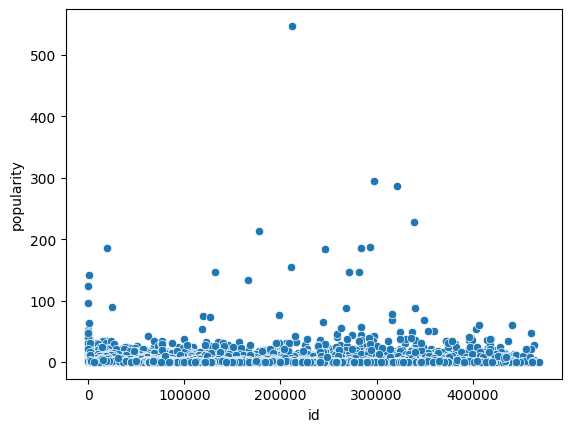

In [30]:
sns.scatterplot(x =movies['id'], y = movies['popularity'])

<Axes: xlabel='release_year', ylabel='popularity'>

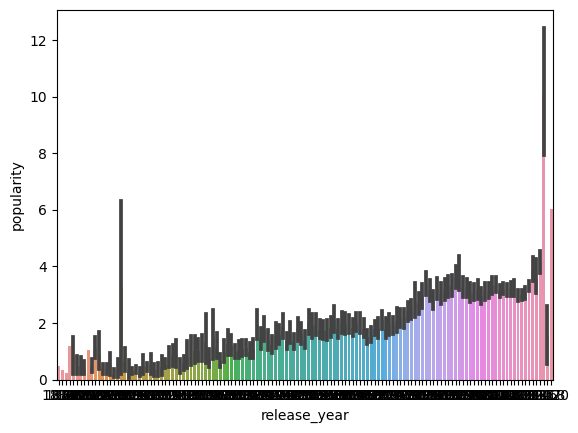

In [31]:
sns.barplot(data=movies, x = 'release_year', y = 'popularity')

se observa que a menos año menos popularidad tienen las peliculas aparte de los casos atípicos

<Axes: xlabel='release_year', ylabel='count'>

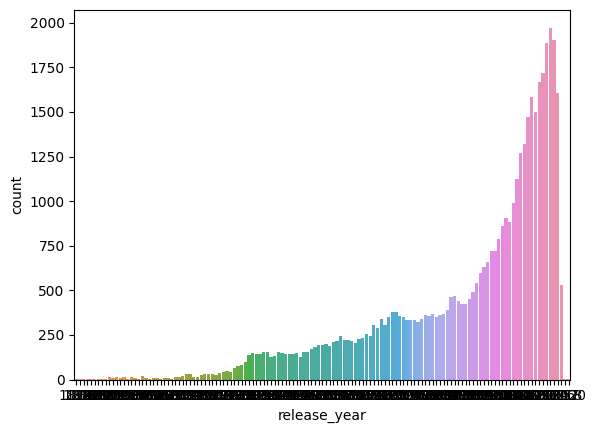

In [32]:
sns.countplot(data = movies, x ='release_year', width=0.9)


In [33]:
movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x)) 
movies['tags'] =  movies['overview'] + movies['genres'] + ' '+ movies['cast'] + movies['Director']
movies_new = movies[['id', 'title', 'tags', 'popularity', 'release_year']]
movies_new = movies_new.dropna(subset=['tags'])

In [34]:
movies_new

,id,title,tags,popularity,release_year
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,1995
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,1995
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,1995
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,1995
...,...,...,...,...,...
45426,30840,Robin Hood,"Yet another version of the classic epic, with ...",5.683753,1991
45428,111109,Century of Birthing,An artist struggles to finish his work while a...,0.178241,2011
45429,67758,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,2003
45430,227506,Satan Triumphant,"In a small town live two brothers, one a minis...",0.003503,1917


In [35]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()


Creamos la función Stem, esta función modifica las palabras para evitar las conjugaciones de la misma como love, loved, loving...etc.

In [36]:
def stem(text):
    list1 = []
    for i in text.split():
        list1.append(ps.stem(i))
    
    return " ".join(list1)

Quitamos los registro con popularidad menos a 1 y año mayor a 1990

In [37]:
#movies_new['tags'] = movies_new['tags'].apply(stem)
#movies_p = movies_new.head(20000) #selecciono una muestra de 20000 segun fecha
movies_new.apply(lambda x: (x['release_year'] > 1990) & (x['popularity'] > 1 ), axis=1).sum()

17079

In [38]:
movies_p = movies_new.loc[(movies_new['release_year'] > 1990) & (movies_new['popularity'] > 1 )]

In [39]:
#movies_p.to_csv('movies_p.csv') #Se exporta la base para trabajar en FastAPI

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features= 5000, stop_words='english')
vector = cv.fit_transform(movies_p['tags']).toarray()
cv.get_feature_names_out()

array(['000', '10', '100', ..., 'zone', 'zoo', 'zooeydeschanel'],
      dtype=object)

Realizamos la vectorización para encontrar la similitud entre las palabras para cada una de las películas y de este modo relaizar la recomendación.

In [41]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vector)

Revisamos el peso del array similarity 

In [42]:
import sys

In [43]:
print(sys.getsizeof(similarity)) # el vector pesa 1.57 Gigabytes

2333538056


In [44]:
def movie_recommend(titulo):
    movie_index = movies_p[movies_p['title']  == titulo].index[0]
    distances = similarity[movie_index]
    movie_list = sorted(list(enumerate(distances)),reverse = True, key = lambda x:x[1])[1:6]
    list_p = []
    for i in movie_list:
        
        j = movies_p.iloc[i[0]].title
        list_p.append(j)
    return {'lista recomendada': list_p}


In [45]:
titulo = 'Jumanji'
resultado = movie_recommend(titulo)
print(resultado)

{'lista recomendada': ['Table No. 21', 'Wreck-It Ralph', 'Beta Test', 'Brainscan', 'Quiz']}


Nueva función de recomendación con todos los registros sin aplicar el filtro de popularidad. Pupularidad se utiliza para la mejor recomendación.

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [47]:
def recomendacion2(titulo):
    vectorizer = TfidfVectorizer(ngram_range=(1,2))
    tfid = vectorizer.fit_transform(movies_new['tags'])
    query = vectorizer.transform([titulo])
    similar = cosine_similarity(query,tfid).flatten()

    ind_simi = np.argpartition(similar, -50)[-50:]
    simil = movies_new.iloc[ind_simi]

    sort_simil = simil.sort_values(by ='popularity', ascending = False)

    popular_simil = sort_simil.head(5)
    resultado_1 = popular_simil['title'].astype(str) 

    return resultado_1

In [48]:
recomendacion2('Toy Story')

1883                     Child's Play 3
2996                        Toy Story 2
2836     Home Alone 2: Lost in New York
2285             Santa Claus: The Movie
14306                            Spread
Name: title, dtype: object